# Bibliotecas

In [12]:
#━━━━━━━━━❮Bibliotecas❯━━━━━━━━━
import os
import geocoder
import cv2
import pandas as pd
import requests
import math
import numpy as np
from keras.utils import np_utils
from geopy.geocoders import Nominatim
from keras.layers import Dense, InputLayer, Dropout
from twilio.rest import Client
from skimage.transform import resize
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
#━━━━━━━━━━━━━━❮◆❯━━━━━━━━━━━━━━

load_dotenv('amb_var.env')

True

# Separação de frames do video de treinamento

In [13]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5)  # frame rate
x = 1
while(cap.isOpened()):
    frameId = cap.get(1)  # current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename = "%d.jpg" % count
        count += 1
        cv2.imwrite(filename, frame)
cap.release()
print("Feito!!")

Feito!!


# Identificação da primeira imagem adquirida do video

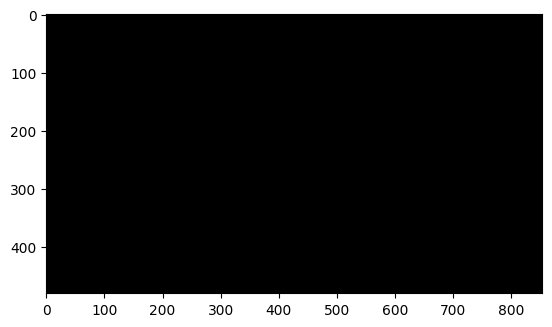

In [14]:
img = plt.imread('0.jpg')
plt.imshow(img)


# Leitura do CSV de classificação

In [15]:
data = pd.read_csv('mapping.csv')
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [16]:
X = []
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)
X = np.array(X)

y = data.Class
dummy_y = np_utils.to_categorical(y)

image = []
for i in range(0, X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224, 224)).astype(int)
    image.append(a)
X = np.array(image)

X = preprocess_input(X, data_format=None)

# Divisão em treino e teste

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)


#━━━━━━━━━━━━━━❮datagen experimental❯━━━━━━━━━━━━━━
# Defining the data augmentation technique
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True
# )
# datagen.fit(X_train)


# Treino do Modelo

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)

X_train = X_train.reshape(155, 7 * 7 * 512)
X_valid = X_valid.reshape(67, 7 * 7 * 512)
train = X_train / X_train.max()
X_valid = X_valid / X_train.max()

model = Sequential()
model.add(InputLayer((7 * 7 * 512,)))
model.add(Dense(units=1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop])


# %%
model.save('Model')

3/3 [==============================] - 5s 1s/step
Epoch 1/100
5/5 [==============================] - 3s 453ms/step - loss: 0.8147 - accuracy: 0.5871 - val_loss: 0.7948 - val_accuracy: 0.6269
Epoch 2/100
5/5 [==============================] - 2s 369ms/step - loss: 0.3954 - accuracy: 0.8645 - val_loss: 0.8066 - val_accuracy: 0.6716
Epoch 3/100
5/5 [==============================] - 2s 368ms/step - loss: 0.2850 - accuracy: 0.8903 - val_loss: 0.8190 - val_accuracy: 0.7015
Epoch 4/100
5/5 [==============================] - 2s 426ms/step - loss: 0.2328 - accuracy: 0.9097 - val_loss: 0.7809 - val_accuracy: 0.7463
Epoch 5/100
5/5 [==============================] - 2s 399ms/step - loss: 0.1173 - accuracy: 0.9742 - val_loss: 0.8060 - val_accuracy: 0.7612
Epoch 6/100
5/5 [==============================] - 2s 379ms/step - loss: 0.1099 - accuracy: 0.9677 - val_loss: 0.8100 - val_accuracy: 0.7164
Epoch 7/100
5/5 [==============================] - 2s 370ms/step - loss: 0.0894 - accuracy: 0.9613 - val

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


# Teste

In [19]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5)  # frame rate
x = 1
while(cap.isOpened()):
    frameId = cap.get(1)  # current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename = "test%d.jpg" % count
        count += 1
        cv2.imwrite(filename, frame)
cap.release()
print("Feito!!")

Feito!!


# Leitura de CSV de teste e preprocessamento 

In [20]:
test = pd.read_csv('test.csv')
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

test_image = [resize(img, preserve_range=True, output_shape=(224, 224)).astype(int) for img in test_img]
test_image = preprocess_input(np.array(test_image), data_format=None)
test_image = base_model.predict(test_image)
test_image = test_image.reshape(9, 7 * 7 * 512)
test_image = test_image / test_image.max()

predictions = model.predict(test_image)


1/1 [==============================] - 0s 64ms/step


# teste pra saber se o modelo esta correto

In [23]:
cap = cv2.VideoCapture('Untitled video - Made with Clipchamp.mp4')
i = 0
flag = 0
while(True):
    ret, frame = cap.read()
    if ret == True:
        if predictions[int(i / 15) % 9][0] < predictions[int(i / 15) % 9][1]:
            predict = "Sem Acidente"
        else:
            predict = "Acidente"
            flag = 1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                    predict,
                    (50, 50),
                    font, 1,
                    (0, 255, 255),
                    3,
                    cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag == 1:
    print('Acidente')

cap.release()
cv2.destroyAllWindows()

Acidente


# Limpeza de Imagens

In [22]:
def apagar_imagens():
    for i in range(600):
        nome_arquivo = f"{i}.jpg"
        if os.path.exists(nome_arquivo):
            os.remove(nome_arquivo)
            print(f"Arquivo {nome_arquivo} apagado.")
        else:
            print(f"Arquivo {nome_arquivo} não encontrado.")

    for i in range(9):
        nome_arquivo = f"test{i}.jpg"
        if os.path.exists(nome_arquivo):
            os.remove(nome_arquivo)
            print(f"Arquivo {nome_arquivo} apagado.")
        else:
            print(f"Arquivo {nome_arquivo} não encontrado.")

delete = input('''Digite D para apagar as fotos gerados: 
Digite N para manter as fotos: ''').upper()

if delete == 'D':
    apagar_imagens()
else:
    print('Imagens Mantidas')

Arquivo 0.jpg apagado.
Arquivo 1.jpg apagado.
Arquivo 2.jpg apagado.
Arquivo 3.jpg apagado.
Arquivo 4.jpg apagado.
Arquivo 5.jpg apagado.
Arquivo 6.jpg apagado.
Arquivo 7.jpg apagado.
Arquivo 8.jpg apagado.
Arquivo 9.jpg apagado.
Arquivo 10.jpg apagado.
Arquivo 11.jpg apagado.
Arquivo 12.jpg apagado.
Arquivo 13.jpg apagado.
Arquivo 14.jpg apagado.
Arquivo 15.jpg apagado.
Arquivo 16.jpg apagado.
Arquivo 17.jpg apagado.
Arquivo 18.jpg apagado.
Arquivo 19.jpg apagado.
Arquivo 20.jpg apagado.
Arquivo 21.jpg apagado.
Arquivo 22.jpg apagado.
Arquivo 23.jpg apagado.
Arquivo 24.jpg apagado.
Arquivo 25.jpg apagado.
Arquivo 26.jpg apagado.
Arquivo 27.jpg apagado.
Arquivo 28.jpg apagado.
Arquivo 29.jpg apagado.
Arquivo 30.jpg apagado.
Arquivo 31.jpg apagado.
Arquivo 32.jpg apagado.
Arquivo 33.jpg apagado.
Arquivo 34.jpg apagado.
Arquivo 35.jpg apagado.
Arquivo 36.jpg apagado.
Arquivo 37.jpg apagado.
Arquivo 38.jpg apagado.
Arquivo 39.jpg apagado.
Arquivo 40.jpg apagado.
Arquivo 41.jpg apagado.
Ar